In [253]:
include("../code/headers.jl")
include("../code/bp.jl")
using ProgressMeter

## Check seaweed code

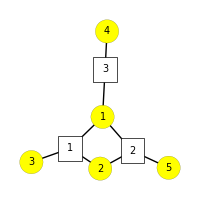

In [103]:
H = [1 1 1 0 0 ; 1 1 0 0 1; 1 0 0 1 0]
fg = FactorGraphGF2(H)
depths,_,_ = lr(fg)   # leaf removal
plot(fg, size=(200,200), randseed=1)

Entered here


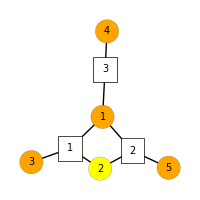

In [104]:
seed = 1
sw = seaweed_rec(fg, seed, depths)
plot(fg, size=(200,200), randseed=1, highlighted_nodes=findall(Bool.(sw)))

# Experiments with Montecarlo

In [217]:
function mc(fg::FactorGraph, N::Int, H::Number, src; init=zeros(Int,fg.n))
    D = sum(xor.(init, src))
    x = copy(init)
    xnew = copy(x)
    d = zeros(N); d[1] = D/fg.n
    hamm = zeros(N); hamm[1] = mean(x)
    marg = x / fg.n
    # leaf removal
    depths = lr(fg)[1]
    isincore = (depths .== 0)
    not_in_core = findall(.!isincore)
    @showprogress for i in 2:N
        # flip seaweed
        sw = seaweed_rec(fg, rand(not_in_core), depths, isincore)
        # accept/reject
        xnew .= xor.(sw,x)
        Dnew = sum(xor.(xnew,src))
        accept = false
        if Dnew < D
            accept = true
        elseif rand() < exp(-2H*(Dnew-D))
            accept = true
        end
        # update
        if accept
            x = xnew
            D = Dnew
        end
        hamm[i] = mean(x)
        marg += x/fg.n
        d[i] = D/fg.n
    end
    hamm, marg, d
end

mc (generic function with 2 methods)

In [194]:
m = 66*100
R = 0.8/3
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = [0,1-r,r]
K = [0,0,1]
nedges = 3m
lambda,rho = nodes2edges(Λ,K)
b = round(Int, sqrt(n)*4)
fg1 = ldpc_graphGF2(n,m,nedges,lambda,rho, accept_multiedges=false)
fg = FactorGraphGF2(fg1.H[1:end-b,:])

Factor Graph with n=8973 variables and m=6221 factors defined on GF(2)


In [237]:
using BenchmarkTools
@btime seaweed_rec(fg, 1);

  32.010 ms (169799 allocations: 16.51 MiB)


In [256]:
seaweed_rec(fg, 1);

LoadError: MethodError: no method matching #seaweed_rec#2372(::SparseVector{Bool,Int64}, ::typeof(seaweed_rec), ::FactorGraphGF2, ::Int64, ::Array{Int64,1}, ::BitArray{1})
Closest candidates are:
  #seaweed_rec#2372(!Matched::BitArray{1}, ::typeof(seaweed_rec), ::FactorGraph, ::Int64, ::Array{Int64,1}, ::BitArray{1}) at /home/crotti/sourcecoding/code/simanneal.jl:273

Get an idea of the minimal distortion at our rate

R = 0.26666666666666666


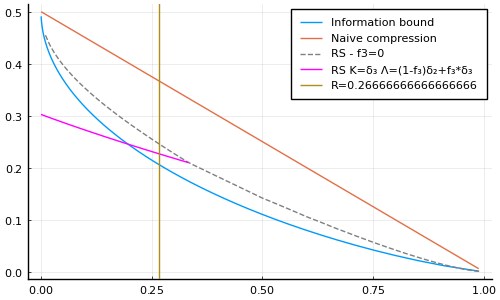

In [195]:
pl = plot_rdb()
@show R
vline!(pl, [R], label="R=$R")
plot(pl, size=(500,300))

In [196]:
N = 10^6
H = 2
dist = 0.2
zero_codeword = zeros(Int,n)
src = [rand()<dist for _ in 1:fg.n];

In [197]:
hamm, marg, d = mc(fg, N, H, src, init=zero_codeword);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:03


Compute "marginals", i.e. for each variable $i$, the proportion of configurations in which it took value $1$. Then plot a histogram

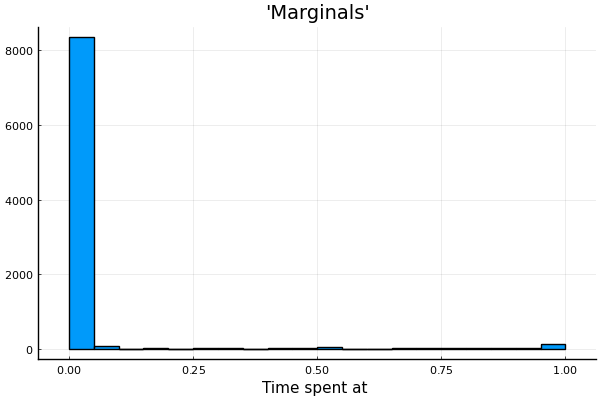

In [61]:
h1 = histogram(marg, bins=25, label="") 
title!("'Marginals'"); xlabel!("Time spent at ")
h1

Plot the hamming weight of configurations throughout the iterations. (One needs to downsample otherwise the plot becomes super slow or it turns out blank)

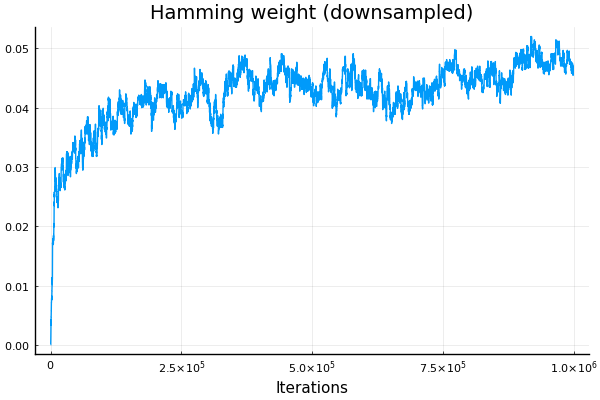

In [62]:
ds = 10
p1 = plot(1:ds:length(hamm), hamm[1:ds:end], label="")
xlabel!("Iterations")
title!("Hamming weight (downsampled)")
p1

Plot the distortion throughout the iterations

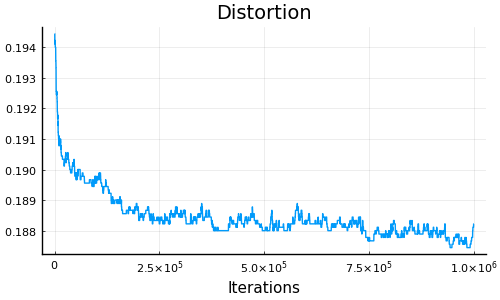

In [70]:
plot(d, label="", size=(500,300)); title!("Distortion"); xlabel!("Iterations")

## Start from the trivial line

In [145]:
B, indep = findbasis_slow(Array(fg.H))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


([0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [103, 337, 704, 1119, 1137, 1279, 1427, 1511, 1773, 1803  …  8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000])

In [162]:
N = 10^6
H = 2
dist = 0.2
src = [rand()<dist for _ in 1:fg.n];

In [172]:
init = zeros(Int, fg.n)
init[indep] .= src[indep]
n,k = size(B)
dep = setdiff(1:n, indep)
init[dep] .= B[dep,:]*init[indep] .% 2
@assert parity(fg,init)==0
init_dist = mean(init .!= src)

0.33744444444444444

In [165]:
hamm1, marg1, d1 = mc(fg, N, H, src, init=init);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:36


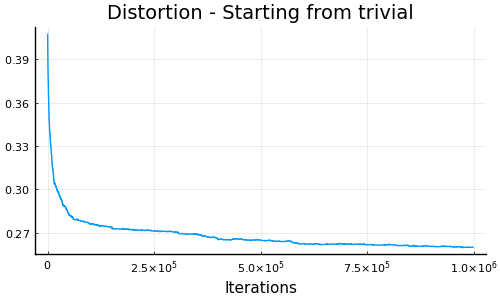

In [214]:
plot(d1, label="", size=(500,300)); title!("Distortion - Starting from trivial"); xlabel!("Iterations")
# ylims!((0.15,0.25))

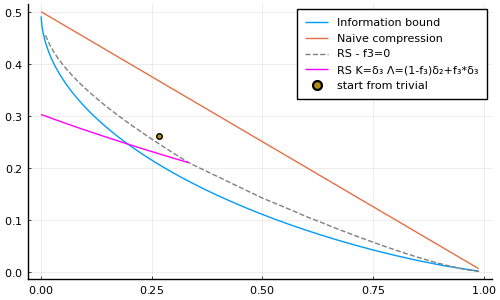

In [169]:
pl1 = plot_rdb()
scatter!(pl1, [R], [d1[end]], label="start from trivial", size=(500,300))

## Uniform random source

In [205]:
B, indep = findbasis_slow(Array(fg.H))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


([0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [362, 533, 908, 1201, 1430, 1515, 1562, 1597, 1779, 1784  …  8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000])

In [229]:
N = 10^6
H = 2
src = rand([0,1], fg.n);

In [230]:
init = zeros(Int, fg.n)
init[indep] .= src[indep]
n,k = size(B)
dep = setdiff(1:n, indep)
init[dep] .= B[dep,:]*init[indep] .% 2
@assert parity(fg,init)==0
init_dist = mean(init .!= src)

0.3456666666666667

In [231]:
hamm2, marg2, d2 = mc(fg, N, H, src, init=init);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:53


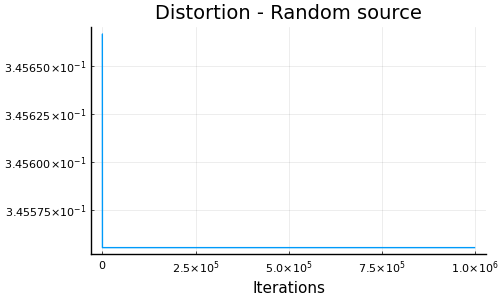

In [232]:
plot(d2, label="", size=(500,300)); title!("Distortion - Random source"); xlabel!("Iterations")
# ylims!((0.15,0.25))

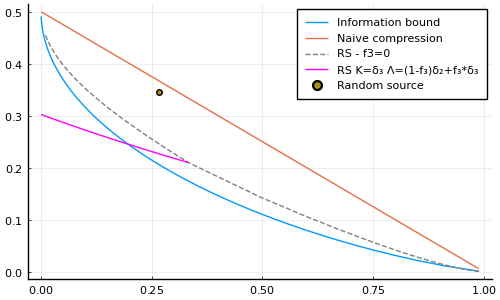

In [233]:
pl1 = plot_rdb()
scatter!(pl1, [R], [d2[end]], label="Random source", size=(500,300))

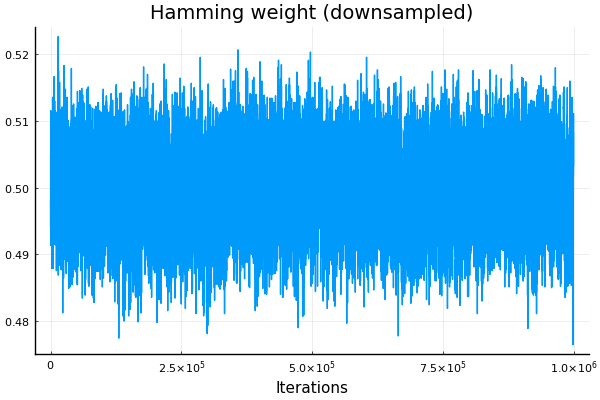

In [234]:
ds = 10
p1 = plot(1:ds:length(hamm2), hamm2[1:ds:end], label="")
xlabel!("Iterations")
title!("Hamming weight (downsampled)")
p1

## Observe size of seaweeds as n grows

Question: what is the right scaling for the number of factors to remove? Probably something sublinear (?)

TODO: non-recursive seaweed

In [31]:
mm = 66 * 2 .^(4:8)
meansizes = fill(NaN,length(mm))
sdsizes = zeros(length(mm))
navg = 10
nseaweeds = 500

R = 0.8/3
r = 1 - 3R
Λ = [0,1-r,r]
K = [0,0,1]
lambda,rho = nodes2edges(Λ,K)
for (i,m) in enumerate(mm)  
    nedges = 3m
    n = round(Int, 3m/(2+r))
    # b is the number of removed factors
#     @show b = round(Int,sqrt(n)*4)
    @show b = round(Int,n/20)
    fg1 = ldpc_graphGF2(n,m,nedges,lambda,rho, accept_multiedges=false)
    fg = FactorGraphGF2(fg1.H[1:end-b,:])
    depths = lr(fg)[1]
    isincore = (depths .== 0)
    not_in_core = findall(.!isincore)
    sw_size = zeros(n)
    @showprogress for s in 1:n
        sw = seaweed(fg, rand(not_in_core), depths, isincore)
        sw_size[s] = sum(sw)
    end
    meansizes[i] = mean(sw_size)
    sdsizes[i] = std(sw_size)/sqrt(n)
    println("m=$m finished. $i of ", length(mm))
end
        

b = round(Int, n / 20) = 4
m=66 finished. 1 of 9
b = round(Int, n / 20) = 9
m=132 finished. 2 of 9
b = round(Int, n / 20) = 18
m=264 finished. 3 of 9
b = round(Int, n / 20) = 36
m=528 finished. 4 of 9
b = round(Int, n / 20) = 72


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


m=1056 finished. 5 of 9
b = round(Int, n / 20) = 144


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


m=2112 finished. 6 of 9
b = round(Int, n / 20) = 288


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


m=4224 finished. 7 of 9
b = round(Int, n / 20) = 576


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


m=8448 finished. 8 of 9
b = round(Int, n / 20) = 1152


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


m=16896 finished. 9 of 9


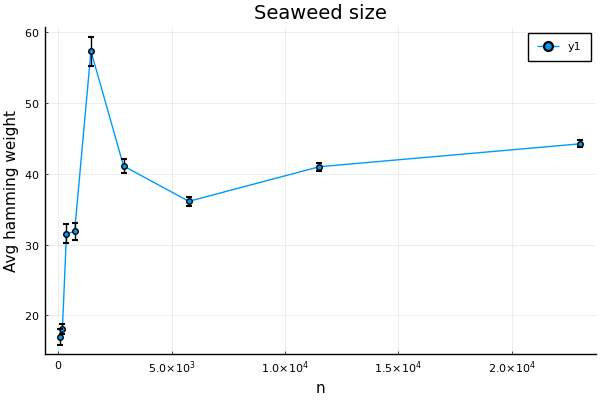

In [37]:
nn = [round(Int, 3m/(2+r)) for m in mm]
plot(nn, meansizes, marker=:circle, yerr=sdsizes)
xlabel!("n"); ylabel!("Avg hamming weight")
title!("Seaweed size")